<a href="https://colab.research.google.com/github/itsdivya1309/Machine-Learning/blob/main/LLMs/Text%20Clustering%20and%20Topic%20Modeling/Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Clustering

Text clustering aims to group similar texts based on their semantic content, meaning, and relationships.

# ArXive's Articles

We will explore the articles in 9 categories namely:
* 'q-bio.BM': 'Biomolecules',
* 'q-bio.CB': 'Cell Behavior',
* 'q-bio.GN': 'Genomics',
* 'q-bio.MN': 'Molecular Networks',
* 'q-bio.NC': 'Neurons and Cognition',
* 'q-bio.OT': 'Other Quantitative Biology',
* 'q-bio.PE': 'Populations and Evolution',
* 'q-bio.QM': 'Quantitative Methods',
* 'q-bio.SC': 'Subcellular Processes',
* 'q-bio.TO': 'Tissues and Organs',

We'll cluster the 45658 articles from the above categories.

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.40G/1.40G [00:18<00:00, 92.3MB/s]
100% 1.40G/1.40G [00:18<00:00, 82.0MB/s]


In [3]:
!unzip arxiv.zip -d arxiv_data

Archive:  arxiv.zip
  inflating: arxiv_data/arxiv-metadata-oai-snapshot.json  


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import json

# Load JSON file
json_file = "arxiv_data/arxiv-metadata-oai-snapshot.json"

# The categories of interest
bio_categories = {
    'q-bio.BM', 'q-bio.CB', 'q-bio.GN', 'q-bio.MN',
    'q-bio.NC', 'q-bio.OT', 'q-bio.PE', 'q-bio.QM', 'q-bio.SC'
}

# Prepare a list to store filtered data
filtered_data = []

# Process the file line by line
with open(json_file, "r") as f:
    for line in f:
        paper = json.loads(line)  # Parse JSON line

        # Check if any category in the paper matches our target categories
        if any(cat in paper['categories'] for cat in bio_categories):
            # Extract only the required fields
            filtered_data.append({
                "title": paper.get("title", ""),
                "authors": paper.get("authors", ""),
                "abstract": paper.get("abstract", ""),
                "doi": paper.get("doi", "N/A")  # Default to "N/A" if DOI is missing
            })

In [6]:
# Convert to a DataFrame
papers = pd.DataFrame(filtered_data)

# Display the first few rows
papers.head()

,title,authors,abstract,doi
0,Molecular Synchronization Waves in Arrays of A...,"Vanessa Casagrande, Yuichi Togashi, Alexander ...",Spatiotemporal pattern formation in a produc...,10.1103/PhysRevLett.99.048301
1,Origin of adaptive mutants: a quantum measurem...,Vasily Ogryzko,This is a supplement to the paper arXiv:q-bi...,None
2,A remark on the number of steady states in a m...,Liming Wang and Eduardo D. Sontag,The multisite phosphorylation-dephosphorylat...,None
3,Complexities of Human Promoter Sequences,"Fangcui Zhao, Huijie Yang, and Binghong Wang","By means of the diffusion entropy approach, ...",10.1016/j.jtbi.2007.03.035
4,Intricate Knots in Proteins: Function and Evol...,"Peter Virnau (1), Leonid A. Mirny (1,2), Mehra...",A number of recently discovered protein stru...,None


In [7]:
# Extract metadata
abstracts = papers['abstract']
titles = papers['title']
abstracts.shape

(45658,)

# A common pipeline for text clustering

1. Convert the text documents to embeddings using an *embedding model*.
2. Reduce the dimensionality of the embeddings with a *dimensionality reduction model*.
3. Find groups of semantically similar documents with a *clustering model*.

---
## Embedding Documents

Choosing embedding models optimized for semantic similarity tasks is especially important for clustering as we attempt to find groups of semantically similar documents. Fortuntely, most embedding models focus on semantic similarity only.

Here, we'll use the `thenlper/gte-base` embedding model, considering its score on clustering task and run time.

In [8]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')

embeddings = embedding_model.encode(abstracts, show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1427 [00:00<?, ?it/s]

In [9]:
# The dimensions of the resulting embeddings
embeddings.shape

(45658, 384)

## Reducing the Dimensionality of Embeddings

As the number of dimensions increases, there is an exponential growth in the number of possible values within each dimension. Finding all subspaces within each dimension becomes increasingly complex. As a result, high-dimensional data can be troublesome for many clustering techniques.

Well known Dimensionality Reduction techniques:
* For clustering raw text data: LSA (Latent Semantic Analysis), NMF (Non-negative Matrix Factorization) or feature selection techniques
* For clustering embeddings: PCA, t-SNE, UMAP
* Deep Learning based approaches: Autoencoders

For this project, we'll go with UMAP (Uniform Manifold Approximation and Projection as it preserves both local & global structure while being computationally efficient.


In [10]:
! pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.5 MB/s eta 0:00:00


In [11]:
import umap

# UMAP model to reduce 384 dimensions to 7
umap_model = umap.UMAP(n_components=7, min_dist=0.1, metric='cosine', random_state=42)

# Fit and transform the embeddings
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [12]:
reduced_embeddings.shape

(45658, 7)

## Cluster the Reduced Embeddings

* For general text clustering: K-Means, Hierarchical, or DBSCAN
* For short text or noisy data: DBSCAN, HDBSCAN
* For document topic clustering: LDA, NMF
* For high-dimensional embeddings (Word2Vec, BERT): Spectral Clustering, HDBSCAN
* For visualization: t-SNE + K-Means, UMAP + DBSCAN

Let's compare *DBSCAN (Density Based Spatial Clustering of Applications and Noise)* and *HDBSCAN (Hierarchical Density Based Clustering of Applications and Noise)*. Both are density-based clustering algorithms and identify the number of clusters on their own.

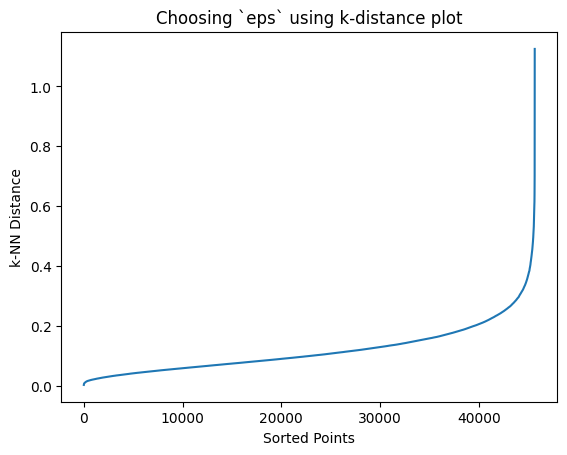

In [13]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)  # Choose k = min_samples
neigh.fit(reduced_embeddings)
distances, _ = neigh.kneighbors(reduced_embeddings)

# Sort distances to find the elbow point
distances = np.sort(distances[:, 4])  # Use the 4th neighbor (k-1)
plt.plot(distances)
plt.ylabel("k-NN Distance")
plt.xlabel("Sorted Points")
plt.title("Choosing `eps` using k-distance plot")
plt.show()

In [14]:
# Form clusters using DBSCAN
from sklearn.cluster import DBSCAN

# Based on the above plot, we choose eps=0.2
dbscan_model = DBSCAN(eps=0.2, min_samples=7, metric='euclidean')
dbscan_model.fit(reduced_embeddings)

DBSCAN(eps=0.2, min_samples=7)

In [15]:
dbscan_clusters = dbscan_model.labels_
len(set(dbscan_clusters))

246

In [16]:
# Reduce the 7-dimensional embedding to 2-D vectors for easier visualization
viz_embeddings = umap.UMAP(n_components=2, min_dist=0.1, metric='cosine', random_state=42).fit_transform(reduced_embeddings)
viz_embeddings.shape

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(45658, 2)

In [17]:
# Create a dataframe
df = pd.DataFrame(viz_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in dbscan_clusters]

# Select outliers and non-outliers (clusters)
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

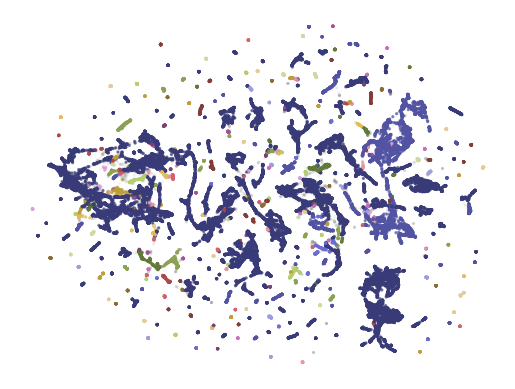

In [18]:
# Plot outliers and non-outliers separately for DBSCAN
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),alpha=0.6, s=2, cmap="tab20b", label="Clusters")
plt.axis("off")
plt.show()

In [19]:
# Form clusters using HDBSCAN
from sklearn.cluster import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom')
hdbscan_model.fit(reduced_embeddings)

HDBSCAN(min_cluster_size=20)

In [20]:
hdbscan_clusters = hdbscan_model.labels_
len(set(hdbscan_model.labels_))

260

In [21]:
# Create a dataframe
df = pd.DataFrame(viz_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in hdbscan_clusters]

# Select outliers and non-outliers (clusters)
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

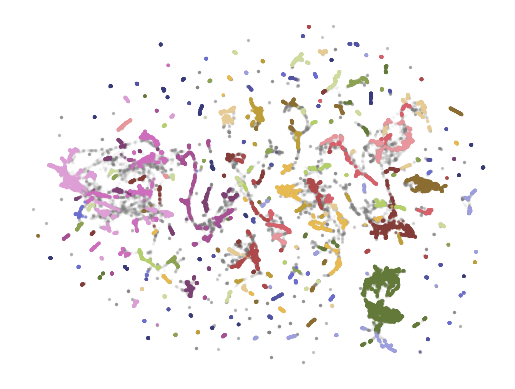

In [22]:
# Plot outliers and non-outliers separately for DBSCAN
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),alpha=0.6, s=2, cmap="tab20b", label="Clusters")
plt.axis("off")
plt.show()

In [23]:
# Form clusters using k-means
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=9, random_state=42, n_init='auto')
kmeans_model.fit(reduced_embeddings)

KMeans(n_clusters=9, random_state=42)

In [24]:
kmeans_clusters = kmeans_model.labels_
len(set(kmeans_model.labels_))

9

In [26]:
# Create a dataframe
df = pd.DataFrame(viz_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in kmeans_clusters]

# Select outliers and non-outliers (clusters)
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

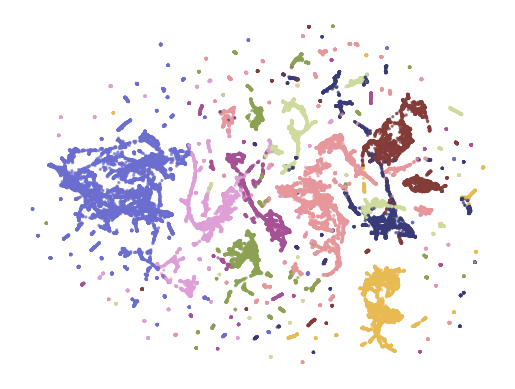

In [27]:
# Plot outliers and non-outliers separately for KMeans
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),alpha=0.6, s=2, cmap="tab20b", label="Clusters")
plt.axis("off")
plt.show()